This notebook demonstrates how to perform standard (Kronecker) multitask regression with kernels.IndexKernel.

This differs from the [hadamard_multitask_gp_regression example notebook](https://github.com/cornellius-gp/gpytorch/blob/master/examples/hadamard_multitask_gp_regression.ipynb) in one key way:
- Here, we assume that we want to learn **all tasks per input**. (The kernel that we learn is expressed as a Krnoecker product of an input kernel and a task kernel).
- In the other notebook, we assume that we want to learn one tasks per input.  For each input, we specify the task of the input that we care about. (The kernel in that notebook is the Hadamard product of an input kernel and a task kernel).

Multitask regression, first introduced in [this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf) learns similarities in the outputs simultaneously. It's useful when you are performing regression on multiple functions that share the same inputs, especially if they have similarities (such as being sinusodial). 

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Training points are every 0.1 in [0,1] (note that they're the same for both tasks)
train_x = torch.linspace(0, 1, 100)

# y1 function is sin(2*pi*x) with noise N(0, 0.04)
train_y1 = torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2
# y2 function is cos(2*pi*x) with noise N(0, 0.04)
train_y2 = torch.cos(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

# Create a train_y which interleaves the two
train_y = torch.stack([train_y1, train_y2], -1)

In [3]:
torch.stack([train_y1, train_y2], -1).size()

torch.Size([100, 2])

In [4]:
from torch import optim
from gpytorch.kernels import RBFKernel, MultitaskKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [5]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        # Default bounds on mean are (-1e10, 1e10)
        self.mean_module = ConstantMean()
        # We use the very common RBF kernel
        self.data_covar_module = RBFKernel()
        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.covar_module = MultitaskKernel(self.data_covar_module, n_tasks=2, rank=1)

    def forward(self, x):
        mean_x = self.mean_module(x)
        mean_x = mean_x.repeat(2)
        covar_x = self.covar_module(x)
        print(covar_x.size())
        return GaussianRandomVariable(mean_x, covar_x)

# Gaussian likelihood is used for regression to give predictive mean+variance
# and learn noise
likelihood = GaussianLikelihood()
model = MultitaskGPModel(train_x, train_y, likelihood)

In [6]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    # Zero prev backpropped gradients
    optimizer.zero_grad()
    # Make predictions from training data
    # Again, note feeding duplicated x_data and indices indicating which task
    output = model(train_x)
    # TODO: Fix this view call!!
    loss = -mll(output, train_y.view(-1))
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

torch.Size([200, 200])
torch.Size([1, 100, 1])
<class 'gpytorch.lazy.interpolated_lazy_variable.InterpolatedLazyVariable'> <class 'gpytorch.lazy.non_lazy_variable.NonLazyVariable'> torch.Size([2, 2]) torch.Size([100, 100])
torch.Size([200, 200])
Iter 1/50 - Loss: 1.136
torch.Size([200, 200])
torch.Size([1, 100, 1])
<class 'gpytorch.lazy.interpolated_lazy_variable.InterpolatedLazyVariable'> <class 'gpytorch.lazy.non_lazy_variable.NonLazyVariable'> torch.Size([2, 2]) torch.Size([100, 100])
torch.Size([200, 200])
Iter 2/50 - Loss: 1.088
torch.Size([200, 200])
torch.Size([1, 100, 1])
<class 'gpytorch.lazy.interpolated_lazy_variable.InterpolatedLazyVariable'> <class 'gpytorch.lazy.non_lazy_variable.NonLazyVariable'> torch.Size([2, 2]) torch.Size([100, 100])
torch.Size([200, 200])
Iter 3/50 - Loss: 1.034
torch.Size([200, 200])
torch.Size([1, 100, 1])
<class 'gpytorch.lazy.interpolated_lazy_variable.InterpolatedLazyVariable'> <class 'gpytorch.lazy.non_lazy_variable.NonLazyVariable'> torch.Siz

torch.Size([200, 200])
torch.Size([1, 100, 1])
<class 'gpytorch.lazy.interpolated_lazy_variable.InterpolatedLazyVariable'> <class 'gpytorch.lazy.non_lazy_variable.NonLazyVariable'> torch.Size([2, 2]) torch.Size([100, 100])
torch.Size([200, 200])
Iter 41/50 - Loss: -0.032
torch.Size([200, 200])
torch.Size([1, 100, 1])
<class 'gpytorch.lazy.interpolated_lazy_variable.InterpolatedLazyVariable'> <class 'gpytorch.lazy.non_lazy_variable.NonLazyVariable'> torch.Size([2, 2]) torch.Size([100, 100])
torch.Size([200, 200])
Iter 42/50 - Loss: -0.056
torch.Size([200, 200])
torch.Size([1, 100, 1])
<class 'gpytorch.lazy.interpolated_lazy_variable.InterpolatedLazyVariable'> <class 'gpytorch.lazy.non_lazy_variable.NonLazyVariable'> torch.Size([2, 2]) torch.Size([100, 100])
torch.Size([200, 200])
Iter 43/50 - Loss: -0.045
torch.Size([200, 200])
torch.Size([1, 100, 1])
<class 'gpytorch.lazy.interpolated_lazy_variable.InterpolatedLazyVariable'> <class 'gpytorch.lazy.non_lazy_variable.NonLazyVariable'> tor

torch.Size([302, 302])
torch.Size([1, 100, 1])
<class 'gpytorch.lazy.interpolated_lazy_variable.InterpolatedLazyVariable'> <class 'gpytorch.lazy.non_lazy_variable.NonLazyVariable'> torch.Size([2, 2]) torch.Size([100, 100])
torch.Size([200, 200])


RuntimeError: 

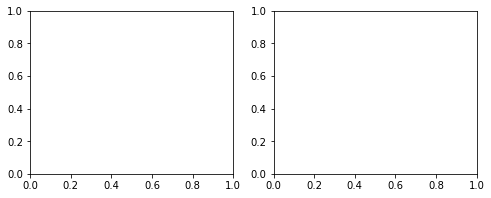

In [7]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))
# Test points every 0.02 in [0,1]

# Make predictions
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))
    # Get mean
    mean = observed_pred.mean()
    mean = mean.view(51, 2)
    # Get lower and upper confidence bounds
    lower, upper = observed_pred.confidence_region()
    lower = lower.view(51, 2)
    upper = upper.view(51, 2)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Define plotting function
def ax_plot():

    # Plot training data as black stars
    y1_ax.plot(train_x.detach().numpy(), train_y1.detach().numpy(), 'k*')
    # Predictive mean as blue line
    y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
    # Shade in confidence 
    y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
    y1_ax.set_ylim([-3, 3])
    y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y1_ax.set_title('Observed Values (Likelihood)')
    
    # Plot training data as black stars
    y2_ax.plot(train_x.detach().numpy(), train_y2.detach().numpy(), 'k*')
    # Predictive mean as blue line
    y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
    # Shade in confidence 
    y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
    y2_ax.set_ylim([-3, 3])
    y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y2_ax.set_title('Observed Values (Likelihood)')

# Plot both tasks
ax_plot()

In [ ]:
%debug

> /mnt/c/Users/Gardn/gpytorch/gpytorch/lazy/lazy_variable.py(419)exact_predictive_mean()
    417         else:
    418             test_train_covar = self[n_train:, :n_train]
--> 419         raise RuntimeError
    420         res = test_train_covar.matmul(precomputed_cache)
    421         if res.ndimension() == 3:

ipdb> test_train_covar.size()
torch.Size([102, 200])
ipdb> precomputed_cache.size()
torch.Size([200])
ipdb> test_train_covar.matmul(precomputed_cache)
torch.Size([1, 51, 1])
<class 'gpytorch.lazy.interpolated_lazy_variable.InterpolatedLazyVariable'> <class 'gpytorch.lazy.non_lazy_variable.NonLazyVariable'> torch.Size([2, 2]) torch.Size([51, 100])
torch.Size([102, 200])
*** RuntimeError: invalid argument 2: size '[100 x -1 x 1]' is invalid for input with 102 elements at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/TH/THStorage.c:37
ipdb> test_train_covar.type()
*** AttributeError: 'LazyEvaluatedKernelVariable' object has no attribute 'type'
ipdb> test_train_covar

ipdb> foo.lazy_vars[0].matmul(rhs.view(foo.lazy_vars[0].size(-1), -1)).size()
torch.Size([2, 100])
ipdb> bar = foo.lazy_vars[0].matmul(rhs.view(foo.lazy_vars[0].size(-1), -1))
ipdb> rhs.size(-1)
200
ipdb> foo.lazy_vars[0].size(-1)
2
ipdb> bar.size()
torch.Size([2, 100])
ipdb> rhs.size()
torch.Size([200])
ipdb> bar.view(2, 200)
*** RuntimeError: invalid argument 2: size '[2 x 200]' is invalid for input with 200 elements at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/TH/THStorage.c:41
ipdb> bar.view(-1, 200)
tensor([[ -75.1583,   86.9491,   -0.4090,   30.6179,   91.3965,   91.5481,
          -49.7600, -118.3790,  134.5144, -100.6011,   97.7339,   -4.8677,
           -1.7592,   13.6046, -173.3760,  -16.7313,  -80.2899,  -18.6967,
          -15.3654,   54.9154,  -48.2408,  -34.6117,   23.4978,  -59.3268,
         -128.5231,  -43.1228,   96.6733,   43.8652,  192.2973,   38.5250,
           39.3612,  -28.3284, -161.5731,   89.6733,   55.3262,   47.3781,
         -127.8768,  -25.

ipdb> res.size()
torch.Size([100, 2])
ipdb> factor = lazy_var._matmul(res)
ipdb> factor.size()
torch.Size([51, 2])
ipdb> n_cols = rhs.size(-1)
ipdb> factor.view(-1, n_cols)
*** RuntimeError: invalid argument 2: size '[-1 x 200]' is invalid for input with 102 elements at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/TH/THStorage.c:37
ipdb> factor.size()
torch.Size([51, 2])
ipdb> n_cols
200


In [12]:
train_y.size()

torch.Size([200])